In [1]:
import pandas as pd

df = pd.read_excel("/content/churn_prediction.xlsx")
df.head(2)

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler

### **1. Data Preprocessing:**

In [3]:
# Change all column names to lowercase for easy to mention:
df.columns = df.columns.str.lower()

In [4]:
# Check imbalance data:
imb_df = df.groupby('churn')['customerid'].count().reset_index()
imb_df['%'] = imb_df['customerid']/sum(imb_df['customerid'])
imb_df

,churn,customerid,%
0,0,4682,0.831616
1,1,948,0.168384


In [5]:
df.shape

(5630, 20)

&rarr; Data is not much imbalanced &rarr; Acceptable

#### **1.1 Missing values:**

<Axes: >

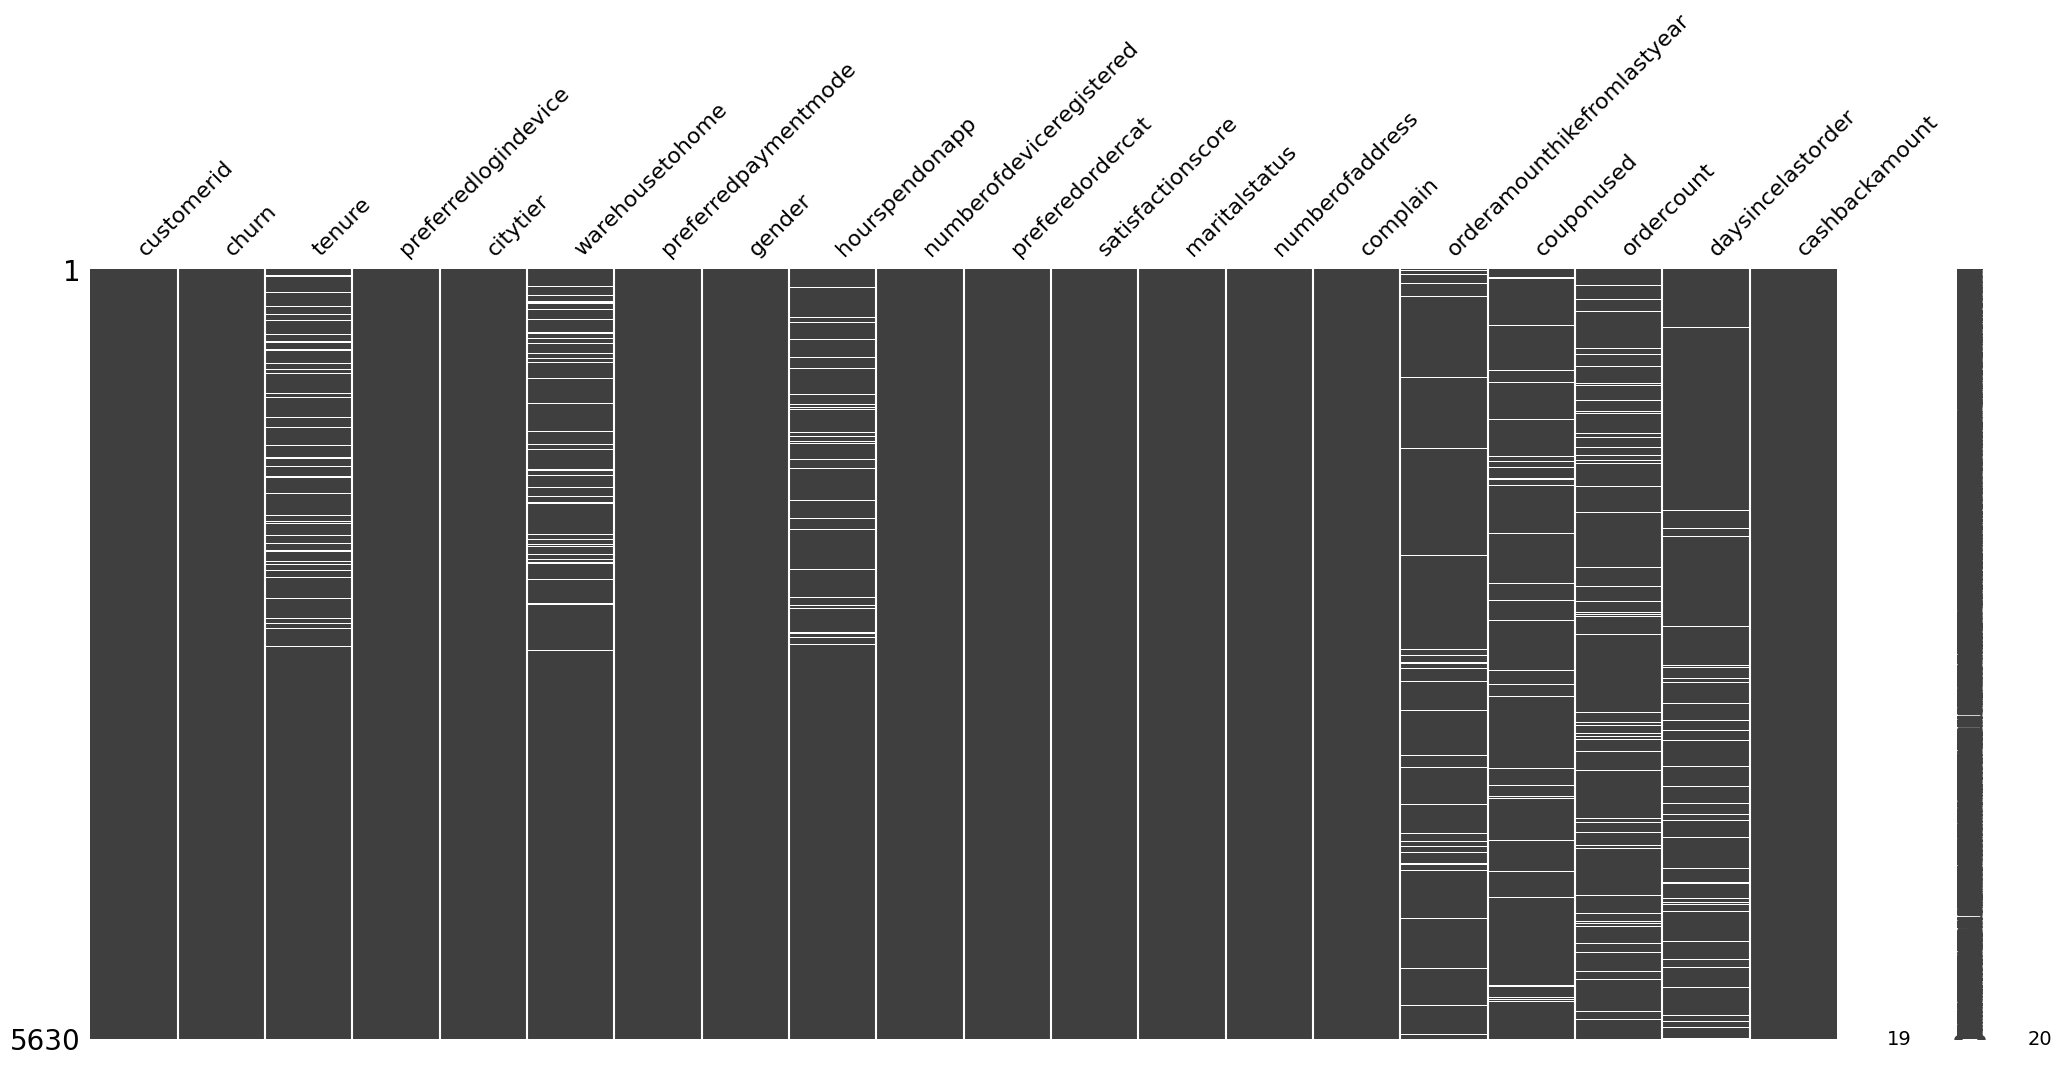

In [6]:
import missingno as msno
msno.matrix(df)

In [7]:
# Check dtypes of columns has missing values:
list_null = df.columns[df.isnull().any()].tolist()
df[list_null].dtypes

,0
tenure,float64
warehousetohome,float64
hourspendonapp,float64
orderamounthikefromlastyear,float64
couponused,float64
ordercount,float64
daysincelastorder,float64


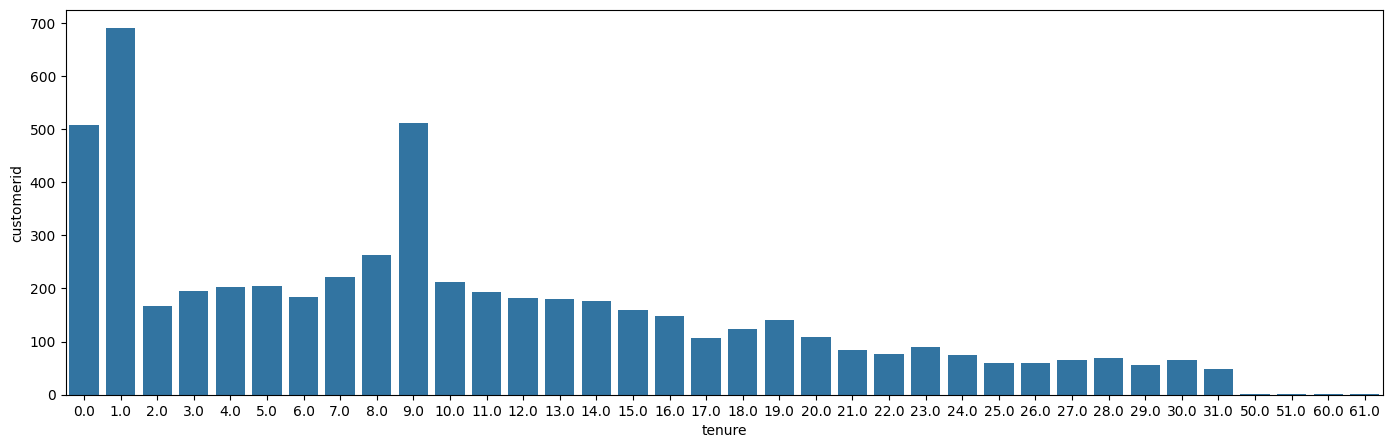

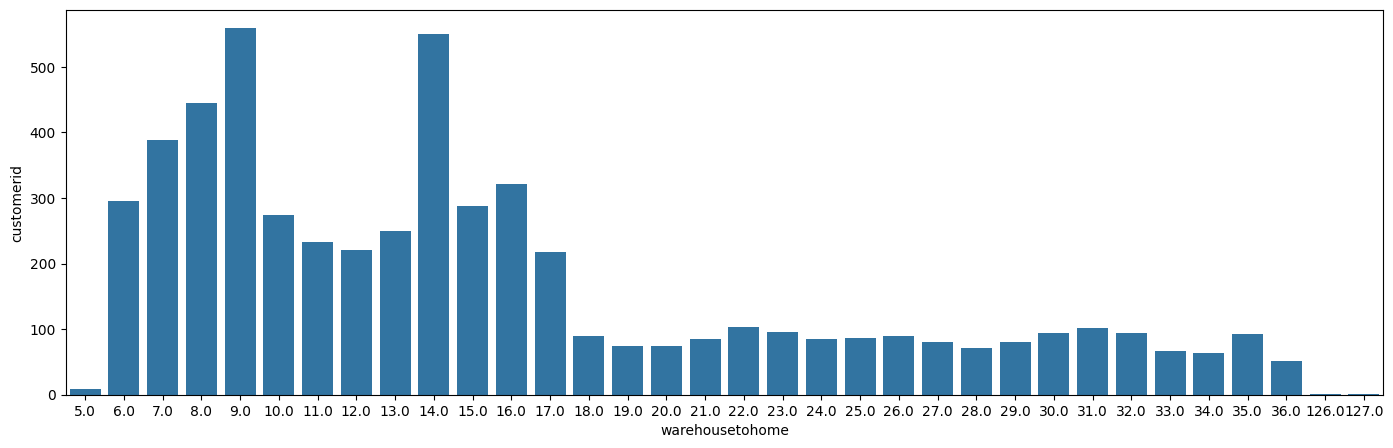

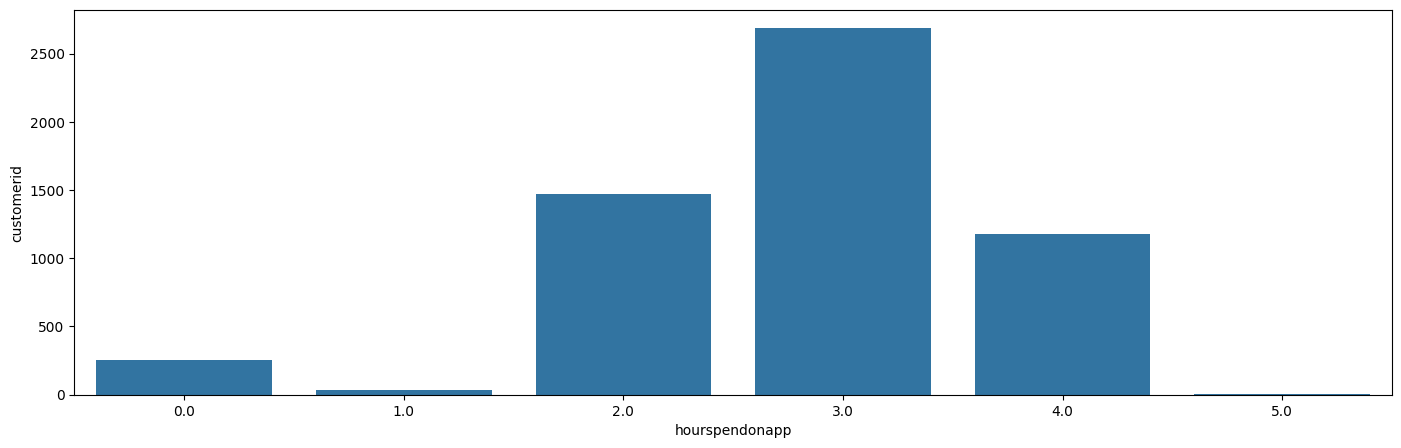

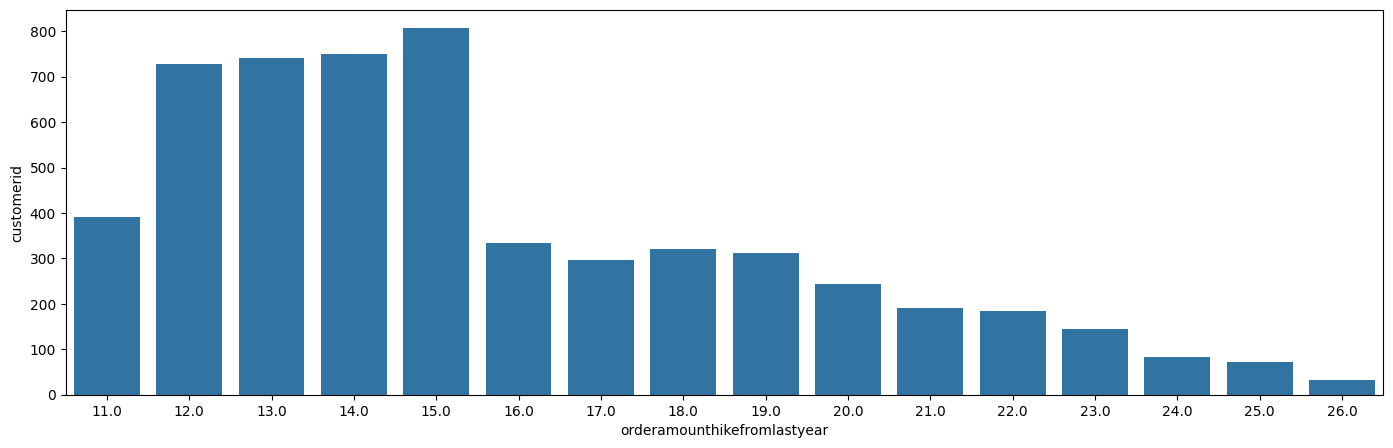

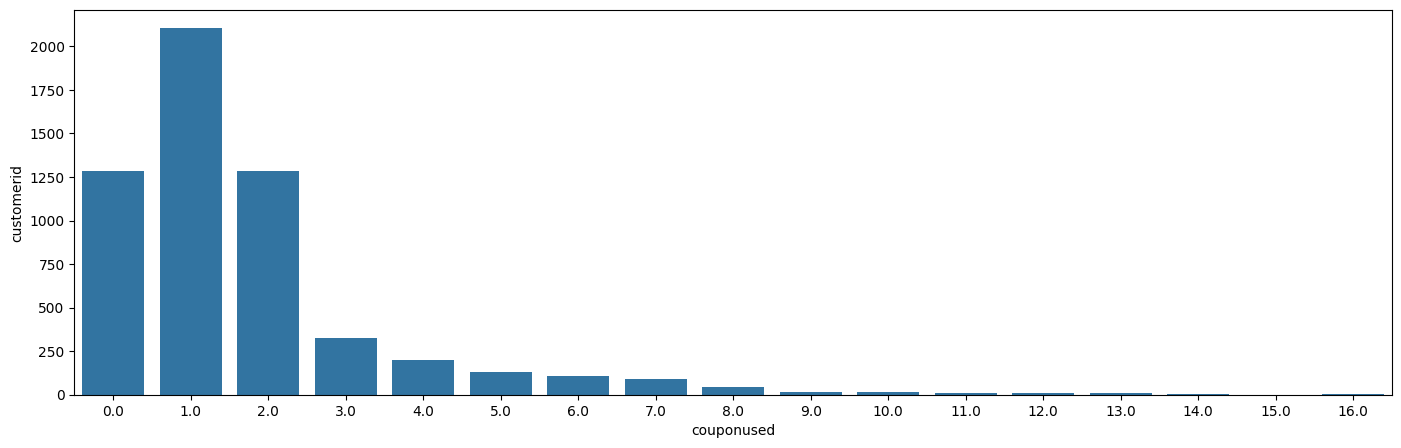

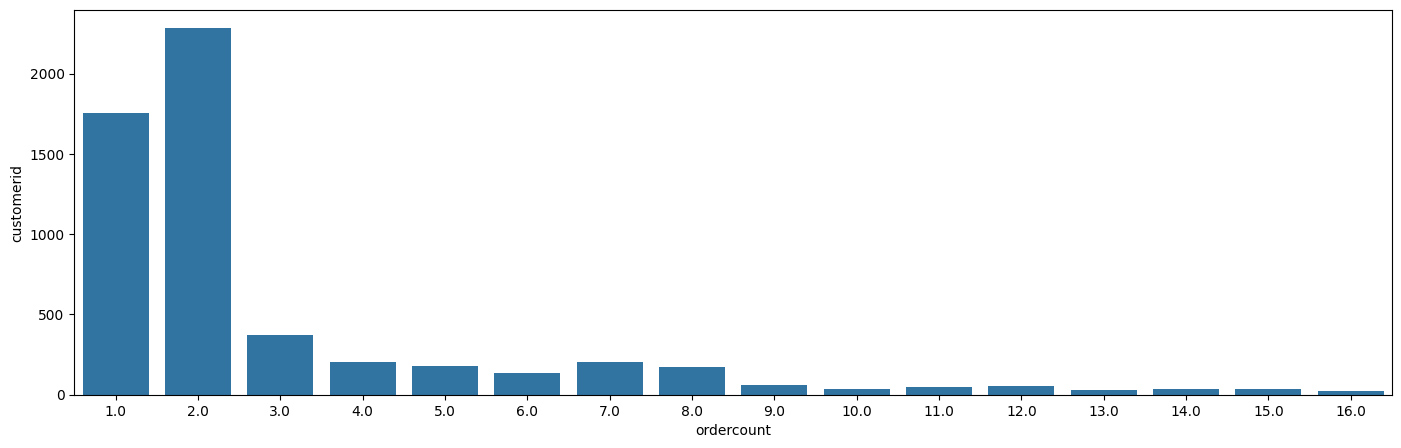

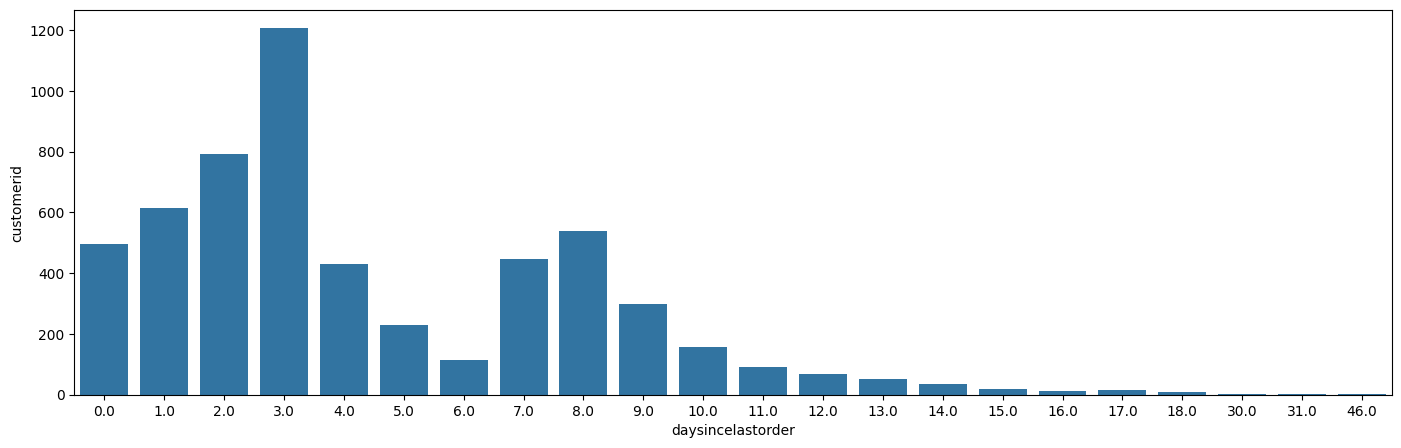

In [46]:
# Check the distribution to decide we will replace with median or 0:
for i in list_null:
    fig, ax = plt.subplots(figsize=(17, 5))
    plot_df = df.groupby(i)[['customerid']].count().reset_index()
    sns.barplot(data = plot_df,x=plot_df[i],y= plot_df['customerid'],ax=ax)
    plt.show()

After review the distribution, we will replace:
   * The decision was made based on: the meaning of columns and the distribution
        - tenure: median
        - warehousetohome: median
        - hourspendonapp: 0
        - orderamounthikefromlastyear: median
        - couponused: 0
        - ordercount: median
        - daysincelastorder: median

<Axes: >

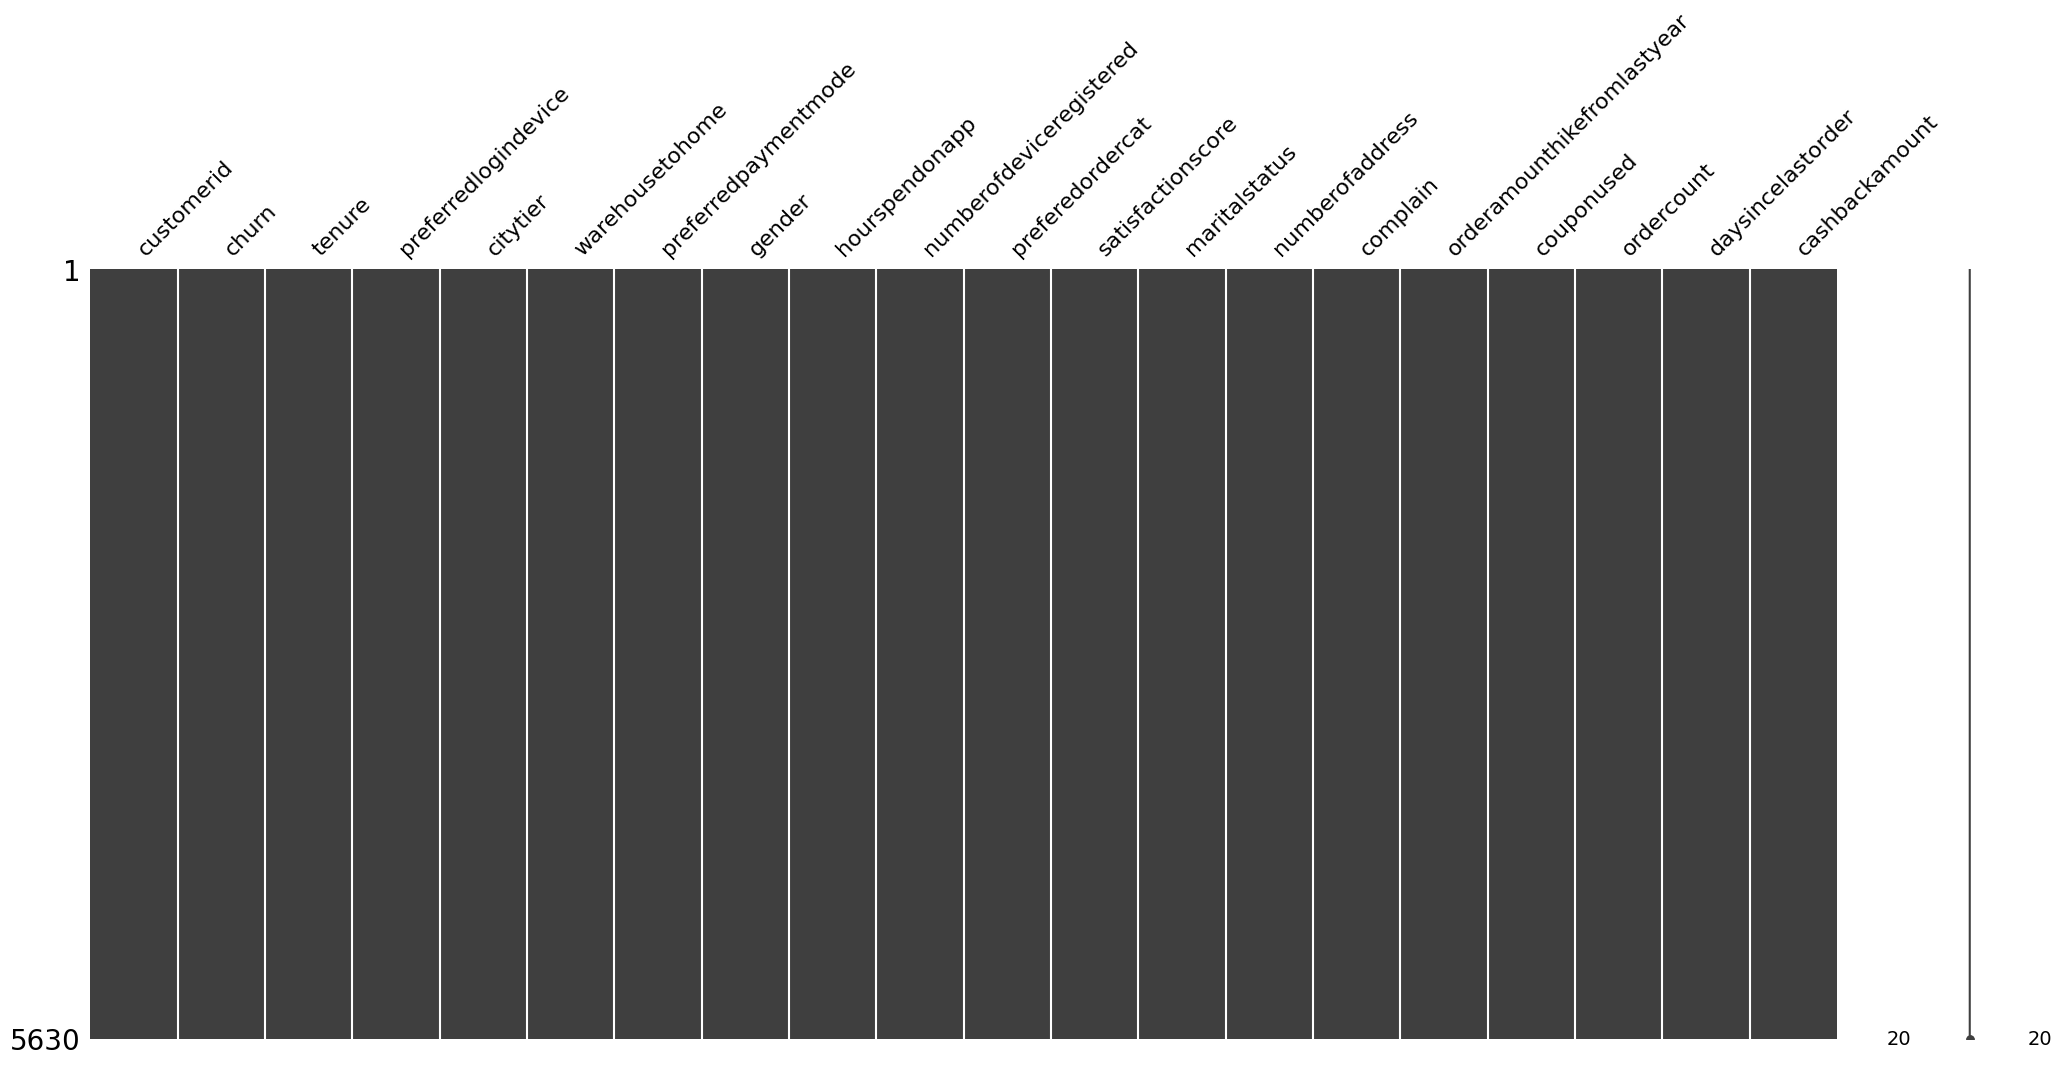

In [9]:
def replace_func(list_columns):
    for i in list_columns:
        if i in ['tenure','warehousetohome','orderamounthikefromlastyear','ordercount','daysincelastorder']:
            median = df[i].median()
            df[i].fillna(median, inplace=True)
        else:
            df[i].fillna(0, inplace=True)

replace_func(list_null)
msno.matrix(df)

#### **1.2 Duplicated Values:**


In [10]:
df.duplicated().any()

False

#### **1.3 Check same meaning values:**


In [11]:
#Check the unique values:
list_obj = df.loc[:, df.dtypes == object].columns.tolist()
for j in list_obj:
  print(f"Unique values of {j}: {df[j].unique()}")

Unique values of preferredlogindevice: ['Mobile Phone' 'Phone' 'Computer']
Unique values of preferredpaymentmode: ['Debit Card' 'UPI' 'CC' 'Cash on Delivery' 'E wallet' 'COD' 'Credit Card']
Unique values of gender: ['Female' 'Male']
Unique values of preferedordercat: ['Laptop & Accessory' 'Mobile' 'Mobile Phone' 'Others' 'Fashion' 'Grocery']
Unique values of maritalstatus: ['Single' 'Divorced' 'Married']


In [12]:
#Replace the same meaning values:
df['preferredlogindevice'] = df['preferredlogindevice'].replace({'Mobile': 'Phone','Mobile Phone':'Phone'})
df['preferredpaymentmode'] = df['preferredpaymentmode'].replace({'CC':'Credit Card','COD':'Cash on Delivery'})
df['preferedordercat'] = df['preferedordercat'].replace({'Mobile Phone':'Phone'})

#Recheck:
for j in list_obj:
  print(f"Unique values of {j}: {df[j].unique()}")

Unique values of preferredlogindevice: ['Phone' 'Computer']
Unique values of preferredpaymentmode: ['Debit Card' 'UPI' 'Credit Card' 'Cash on Delivery' 'E wallet']
Unique values of gender: ['Female' 'Male']
Unique values of preferedordercat: ['Laptop & Accessory' 'Mobile' 'Phone' 'Others' 'Fashion' 'Grocery']
Unique values of maritalstatus: ['Single' 'Divorced' 'Married']


## **Question 1:**

1. Churned users usually are new users &rarr; Provide more promotion for new users, or increase the new users experience
2. Churned users usually receive less cashback than not churn &rarr; Increase the cashback ratio
3. Churned users complain more &rarr; deep dive what these churned users complain about, and provide the solution

#### **1.3 EDA by applying Random Forest first:**

In [13]:
#Encoding:
cate_columns = df.loc[:, df.dtypes == object].columns.tolist()
cate_columns

['preferredlogindevice',
 'preferredpaymentmode',
 'gender',
 'preferedordercat',
 'maritalstatus']

In [14]:
encoded_df = pd.get_dummies(df, columns = cate_columns,drop_first=True)
encoded_df.head(2)

,customerid,churn,tenure,citytier,warehousetohome,hourspendonapp,numberofdeviceregistered,satisfactionscore,numberofaddress,complain,...,preferredpaymentmode_E wallet,preferredpaymentmode_UPI,gender_Male,preferedordercat_Grocery,preferedordercat_Laptop & Accessory,preferedordercat_Mobile,preferedordercat_Others,preferedordercat_Phone,maritalstatus_Married,maritalstatus_Single
0,50001,1,4.0,3,6.0,3.0,3,2,9,1,...,False,False,False,False,True,False,False,False,False,True
1,50002,1,9.0,1,8.0,3.0,4,3,7,1,...,False,True,True,False,False,True,False,False,False,True


In [15]:
#Normalization:
scaler = MinMaxScaler()
model=scaler.fit(encoded_df)
scaled_data=model.transform(encoded_df)

scaled_df = pd.DataFrame(scaled_data, columns = encoded_df.columns.tolist())
scaled_df.drop(columns = 'customerid',inplace=True)
scaled_df.head(2)

,churn,tenure,citytier,warehousetohome,hourspendonapp,numberofdeviceregistered,satisfactionscore,numberofaddress,complain,orderamounthikefromlastyear,...,preferredpaymentmode_E wallet,preferredpaymentmode_UPI,gender_Male,preferedordercat_Grocery,preferedordercat_Laptop & Accessory,preferedordercat_Mobile,preferedordercat_Others,preferedordercat_Phone,maritalstatus_Married,maritalstatus_Single
0,1.0,0.065574,1.0,0.008197,0.6,0.4,0.25,0.380952,1.0,0.000000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.147541,0.0,0.024590,0.6,0.6,0.50,0.285714,1.0,0.266667,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [16]:
#Applying initial Random Forest (without splitting train/test):

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

x=scaled_df.drop('churn', axis = 1)
y=scaled_df[['churn']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

clf_ranf = RandomForestClassifier()
clf_ranf.fit(x_train,y_train)

y_pred = clf_ranf.predict(x_test)

print(f'Balance accuracy of test set: {balanced_accuracy_score(y_test, y_pred)}')

Balance accuracy of test set: 0.8987508321835025


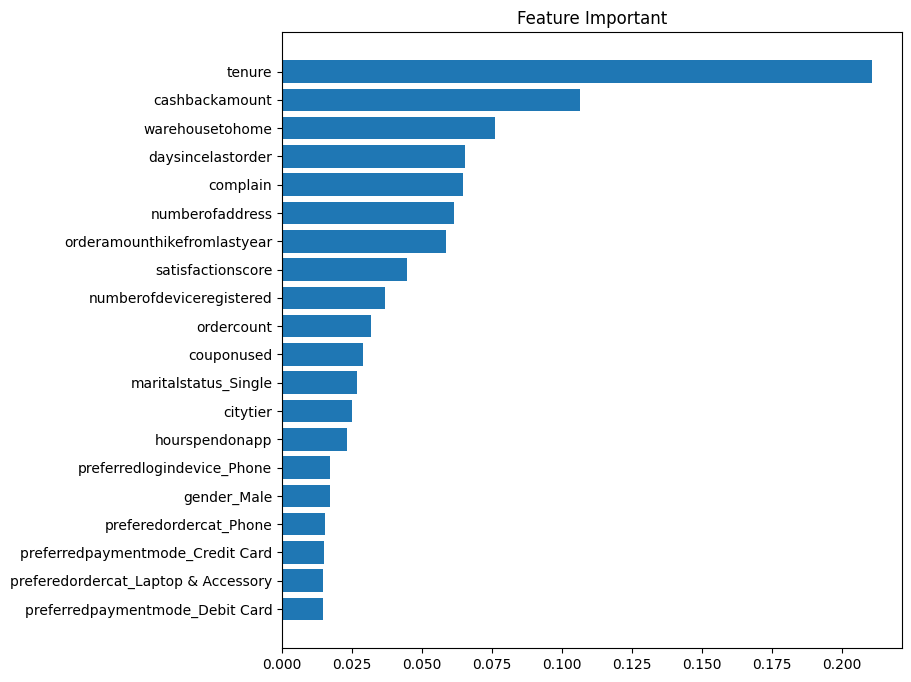

In [17]:
#Show Feature Importance:

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(x.columns, clf_ranf.feature_importances_):
    feats[feature] = importance #add the name/value pair

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances = importances.sort_values(by='Gini-importance', ascending=True)

importances = importances.reset_index()


# Create bar chart
plt.figure(figsize=(8, 8))
plt.barh(importances.tail(20)['index'][:20], importances.tail(20)['Gini-importance'])

plt.title('Feature Important')

# Show plot
plt.show()

As Feature Importance show, we can see these features can have high relation with target columns:
* Tenure
* Cashback amount
* Distance from warehouse to home
* Complain
* Days since Last order

&rarr; We will analyse and visualize these features for more insights.


#### **1.4 Analyse features from initial Random Forest model:**

* Tenure
* Cashback amount
* Distance from warehouse to home
* Complain
* Days since Last order

In [18]:
def count_percentage(df, column, target, count):
    '''
    This function to create the table calculate the percentage of fraud/non-fraud
    transaction on total transaction group by category values
    '''

    # Create 2 dataframes of fraud and non-fraud
    fraud = df[df[target]==1].groupby(column)[[count]].count().reset_index().sort_values(ascending=False, by = count)
    not_fraud = df[df[target]==0].groupby(column)[[count]].count().reset_index().sort_values(ascending=False, by = count)

    #Merge 2 dataframe into one:
    cate_df = fraud.merge(not_fraud, on = column , how = 'outer')
    cate_df = cate_df.fillna(0)
    cate_df.rename(columns = {count+'_x':'fraud',count+'_y':'not_fraud'}, inplace = True)

    #Caculate the percentage:
    cate_df['%'] = cate_df['fraud']/(cate_df['fraud']+cate_df['not_fraud'])
    cate_df = cate_df.sort_values(by='%', ascending=False)

    return cate_df

##### **1.4.1 Tenure**  New users are churned more than old users (tenure = 0 or 1)

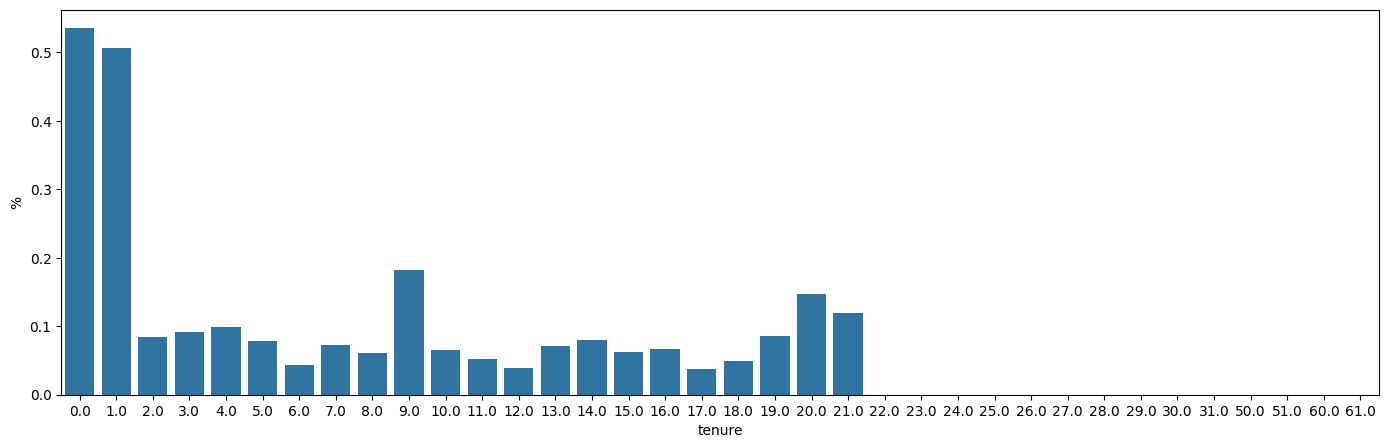

In [49]:
plot_df = count_percentage(df, 'tenure', 'churn', 'customerid')
#Visualize the data:
fig, ax = plt.subplots(figsize=(17, 5))
sns.barplot(data=plot_df, x='tenure',y='%', ax=ax);

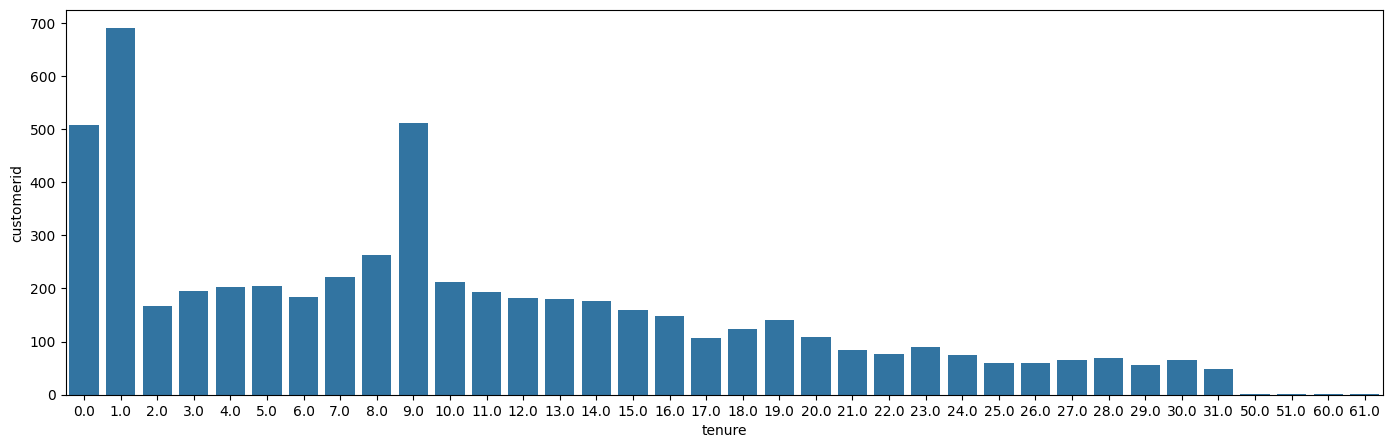

In [50]:
count_df = df.groupby('tenure')[['customerid']].count().reset_index()
#Visualize the data:
fig, ax = plt.subplots(figsize=(17, 5))
sns.barplot(data=count_df, x='tenure',y='customerid', ax=ax);

### ->The results show that the average range time for customers `below 11 months` is `highest at 1 month`.

##### **1.4.2 Warehouse to home**  Not significantly related

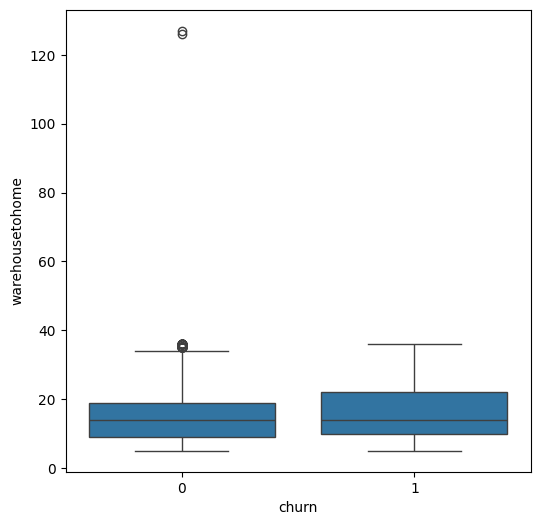

In [51]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=df, x='churn',y='warehousetohome',ax=ax);

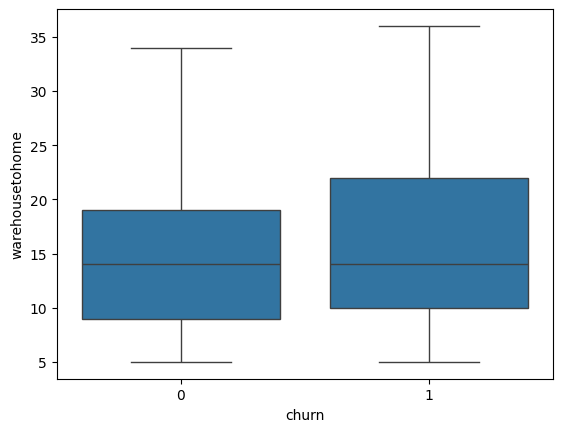

In [53]:
sns.boxplot(data=df, x='churn',y='warehousetohome', showfliers = False);

For both churn & not churn:
* The median, pt25, mean, pt75 is quite the same --> The centralize of data is the same
* For not churn, data has some outliers --> This can be not significant enough to consider it as an insight for not churn

&rarr; There're no strong evidences show that there different between churn and not churn for warehousetohome --> We will exclude this features when apply model for not being bias.

##### **1.4.3 Days since last order:** churn users with complain = 1 have higher days since orders than churned users with complain = 0  

<Axes: xlabel='churn', ylabel='daysincelastorder'>

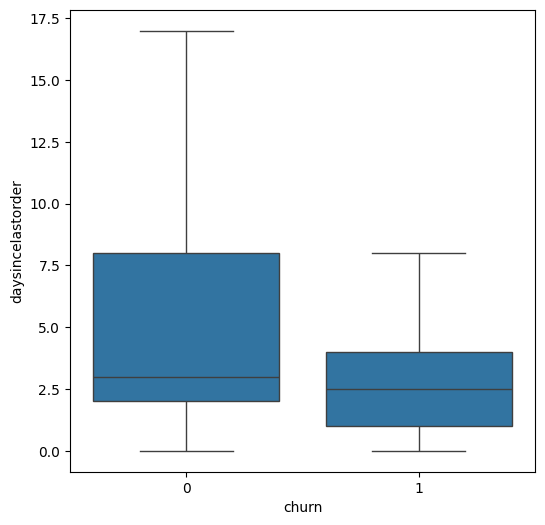

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=df, x='churn',y='daysincelastorder',ax=ax, showfliers = False)

From this chart, we see for churned users, they had orders recently (the day since last order less than not churned users) --> This quite strange, we should monitor more features for this insight (satisfaction_score, complain,..)

<Axes: xlabel='complain', ylabel='daysincelastorder'>

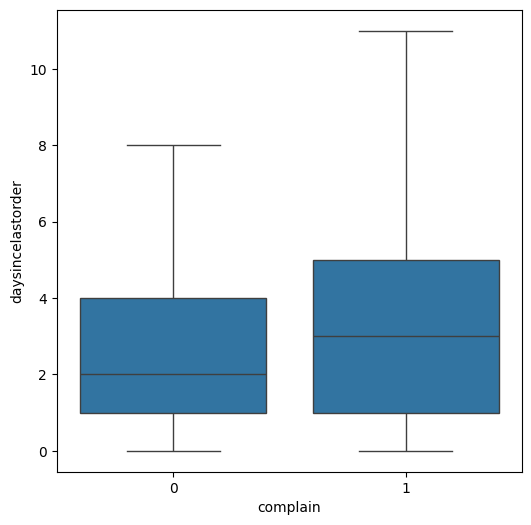

In [24]:
churn_df = df[df['churn']==1]
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=churn_df, x='complain',y='daysincelastorder',ax=ax, showfliers = False)

For churned users with complain = 1, they had daysincelastorder higher than churn users with compain = 0

##### **1.4.4 Cashback amount**  Churn users recevied cashback amount less than not churn users.

<Axes: xlabel='churn', ylabel='cashbackamount'>

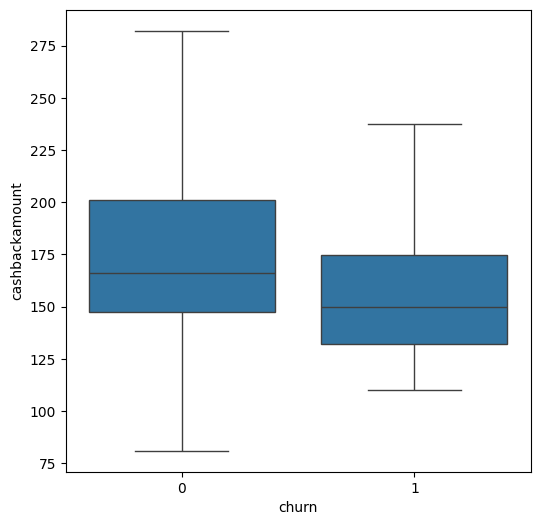

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.boxplot(data=df, x='churn',y='cashbackamount',ax=ax, showfliers = False)

Churn users recevied cashback amount less than not churn users.

##### **1.4.5 Complain** The number of users complain on churn is higher than not churn

<Axes: xlabel='complain', ylabel='%'>

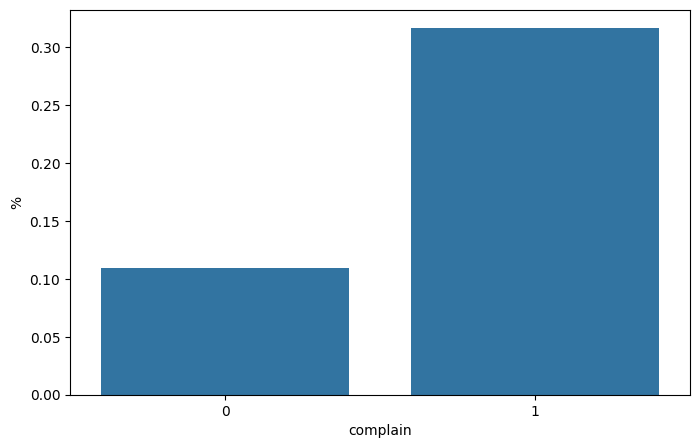

In [26]:
plot_df = count_percentage(df, 'complain', 'churn', 'customerid')
#Visualize the data:
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(data=plot_df, x='complain',y='%', ax=ax)

##### **1.4.6 Conclusion & Suggestion**

1. Churned users usually are new users &rarr; Provide more promotion for new users, or increase the new users experience
2. Churned users usually receive less cashback than not churn &rarr; Increase the cashback ratio
3. Churned users complain more &rarr; deep dive what these churned users complain about, and provide the solution

## **Question 2:**

1. Remove warehousetohome column
2. Apply Random Forest model and fine tuning

### **2. Feature Transforming:**

In [27]:
# Remove Warehouse to home and number of address =19,20
df_model = df.drop(columns = 'warehousetohome')
df_model = df_model.drop(df_model[(df_model.numberofaddress == 19)|(df_model.numberofaddress == 20)].index)
df_model.head(1)

,customerid,churn,tenure,preferredlogindevice,citytier,preferredpaymentmode,gender,hourspendonapp,numberofdeviceregistered,preferedordercat,satisfactionscore,maritalstatus,numberofaddress,complain,orderamounthikefromlastyear,couponused,ordercount,daysincelastorder,cashbackamount
0,50001,1,4.0,Phone,3,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93


In [28]:
cate_columns = df_model.loc[:, df_model.dtypes == object].columns.tolist()
encoded_df = pd.get_dummies(df_model, columns = cate_columns,drop_first=True)
encoded_df.shape

(5628, 27)

In [29]:
#Scale Feature:
scaler = MinMaxScaler()
model=scaler.fit(encoded_df)
scaled_data=model.transform(encoded_df)

scaled_df = pd.DataFrame(scaled_data, columns = encoded_df.columns.tolist())
scaled_df.drop(columns = 'customerid',inplace=True)

### **3. Model Training & Evaluation**

#### **3.1 Split train/test set:**

In [30]:
from sklearn.model_selection import train_test_split

x=scaled_df.drop('churn', axis = 1)
y=scaled_df[['churn']]

x_train, x_temp, y_train, y_temp = train_test_split(x,y, test_size=0.3, random_state=42)

x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

# Print the sizes of the splits
print(f"Training set size: {len(x_train)}")
print(f"Validation set size: {len(x_val)}")
print(f"Test set size: {len(x_test)}")


Training set size: 3939
Validation set size: 844
Test set size: 845


#### **3.2 Apply model: Random Forest**

In [31]:
from sklearn.ensemble import RandomForestClassifier

clf_rand = RandomForestClassifier(max_depth=15, random_state=0, n_estimators = 100)

clf_rand.fit(x_train, y_train)
y_ranf_pre_train = clf_rand.predict(x_train)
y_ranf_pre_val = clf_rand.predict(x_val)

In [32]:
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_ranf_pre_train)}')
print(f'Balance accuracy of test set: {balanced_accuracy_score(y_val, y_ranf_pre_val)}')

Balance accuracy of train set: 0.9985590778097982
Balance accuracy of test set: 0.9228364367934342


#### **3.3 Enhance Random Forest model**

In [33]:
from sklearn.model_selection import GridSearchCV
# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [20, 30,40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

param_grid = {
    'n_estimators': [100],
    'max_depth': [20, 30],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'bootstrap': [False]
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(clf_rand, param_grid, cv=5, scoring='balanced_accuracy')

# Fit the model
grid_search.fit(x_train, y_train)

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

# Evaluate the best model on the test set
best_clf = grid_search.best_estimator_
print(best_clf)

Best Parameters:  {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
RandomForestClassifier(bootstrap=False, max_depth=20, random_state=0)


**Re-apply model with new parameters:**

In [34]:
best_params = grid_search.best_params_
clf_rand_after = RandomForestClassifier(**best_params,random_state=0)

clf_rand_after.fit(x_train, y_train)
y_ranf_aft_train = clf_rand_after.predict(x_train)
y_ranf_aft_val = clf_rand_after.predict(x_val)

In [35]:
print(f'Balance accuracy of train set: {balanced_accuracy_score(y_train, y_ranf_aft_train)}')
print(f'Balance accuracy of val set: {balanced_accuracy_score(y_val, y_ranf_aft_val)}')

Balance accuracy of train set: 1.0
Balance accuracy of val set: 0.945572282614908


**&rarr; The balanced accuracy increase to 94 &rarr; Can use this model as final model**

In [36]:
y_pred_test = clf_rand_after.predict(x_test)
print(f'Balance accuracy of val set: {balanced_accuracy_score(y_test, y_pred_test)}')

Balance accuracy of val set: 0.9263957491393504


**When reapply model on test set, the accuracy is 92%, acceptable**

## **Question 3:**

* Use K-Means to clustering churn-users groups.
* Find the insight between the groups


### **1. Get the data prepared**

We will get all features of churned users for clustering

In [37]:
#Prepare data:
df_churned = df[df['churn']==1]
df_churned.drop(columns = ['customerid','churn'],inplace=True)
print(df_churned.shape)
df_churned.head(2)

(948, 18)


,tenure,preferredlogindevice,citytier,warehousetohome,preferredpaymentmode,gender,hourspendonapp,numberofdeviceregistered,preferedordercat,satisfactionscore,maritalstatus,numberofaddress,complain,orderamounthikefromlastyear,couponused,ordercount,daysincelastorder,cashbackamount
0,4.0,Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,9.0,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90


In [38]:
#Transform data:
encoded_df = pd.get_dummies(df_churned, columns = cate_columns,drop_first=True)

#Normalization:
scaler = MinMaxScaler()
model=scaler.fit(encoded_df)
scaled_data=model.transform(encoded_df)
scaled_df = pd.DataFrame(scaled_data, columns = encoded_df.columns.tolist())

In [39]:
scaled_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 948 entries, 0 to 947
Data columns (total 26 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   tenure                               948 non-null    float64
 1   citytier                             948 non-null    float64
 2   warehousetohome                      948 non-null    float64
 3   hourspendonapp                       948 non-null    float64
 4   numberofdeviceregistered             948 non-null    float64
 5   satisfactionscore                    948 non-null    float64
 6   numberofaddress                      948 non-null    float64
 7   complain                             948 non-null    float64
 8   orderamounthikefromlastyear          948 non-null    float64
 9   couponused                           948 non-null    float64
 10  ordercount                           948 non-null    float64
 11  daysincelastorder               

In [40]:
from sklearn.decomposition import PCA
pca=PCA(n_components=3)
pca.fit(scaled_df)
PCA_df=pd.DataFrame(pca.transform(scaled_df), columns=['PC1', 'PC2', 'PC3'])
PCA_df.head()

,PC1,PC2,PC3
0,-0.809213,0.765859,0.515580
1,-0.267497,-0.190208,0.101365
2,-0.539625,-0.360539,0.715201
3,-0.689231,0.743022,0.081638
4,-0.019933,-0.192832,-0.424121


In [41]:
pca.explained_variance_ratio_

array([0.14327788, 0.12583358, 0.10116543])

### **2. Apply KMeans model**

#### 2.1. Choosing K:

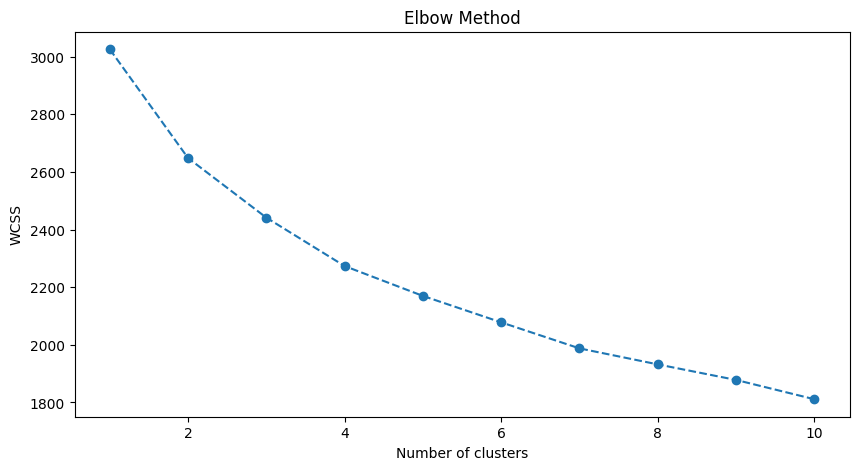

In [42]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap

ss = []
max_clusters = 10
for i in range(1, max_clusters+1):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_df)
    # Inertia method returns WCSS for that model
    ss.append(kmeans.inertia_)

# Plot the Elbow method
plt.figure(figsize=(10,5))
plt.plot(range(1, max_clusters+1), ss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()



- When applying Elbow method, we see there're no clear elbow points.
- Our hypothesis is that the data is sporadic, which means there're no clearly common patterns between data, and we can not cluster them into groups.

**Our suggestions for next steps:**

* We can collect more data of churned users: by collect real data or using our above supervised model to predict and use it as ground truth data for clustering model

* Business can offer the promotion for all churned users and collect results. These results can be used as features in the data for the next model.